In [126]:
# Import modules
import datetime
import spiceypy
import numpy as np

# Load the SPICE kernels via a meta file
spiceypy.furnsh('kernel_meta.txt')

In [127]:
# We want to compute the Solar System barycentre (SSB) w.r.t to the centre of
# the Sun for a certain time interval
# First, we set an initial time in UTC.
init_time_utc = datetime.datetime(year=2000, month=1, day=1, \
                                  hour=0, minute=0, second=0)

# Add a number of days; you can play around with the datetime variables; but
# leave it as it is for the first try, since other computations and comments
# are based on this value.
delta_days = 10000
end_time_utc = init_time_utc + datetime.timedelta(days=delta_days)

# Convert the datetime objects now to strings
init_time_utc_str = init_time_utc.strftime('%Y-%m-%dT%H:%M:%S')
end_time_utc_str = end_time_utc.strftime('%Y-%m-%dT%H:%M:%S')

# Print the starting and end times
print('Init time in UTC: %s' % init_time_utc_str)
print('End time in UTC: %s\n' % end_time_utc_str)

# Convert to Ephemeris Time (ET) using the SPICE function utc2et.
init_time_et = spiceypy.utc2et(init_time_utc_str)
end_time_et = spiceypy.utc2et(end_time_utc_str)

Init time in UTC: 2000-01-01T00:00:00
End time in UTC: 2027-05-19T00:00:00



In [128]:
# Now we compute the position of the Solar System's barycentre w.r.t. our Sun:
# First we set an empty list that stores later all x, y, z components for each
# time step
ssb_wrt_sun_position = []

# Time interval
time_interval_et = np.linspace(init_time_et, end_time_et, delta_days)

# Each time step is used in this for-loop to compute the position of the SSB
# w.r.t. the Sun. We use the function spkgps.
for time_interval_et_f in time_interval_et:
    _position, _ = spiceypy.spkgps(targ=0, et=time_interval_et_f, \
                                   ref='eclipj2000', obs=10)

    # Append the result to the final list
    ssb_wrt_sun_position.append(_position)

# Convert the list to a numpy array
ssb_wrt_sun_position = np.array(ssb_wrt_sun_position)

In [129]:
# We want to visualise the results, to a get feeling of the movement. Is the
# movement somehow interesting and / or significant?

# Using km are not intuitive. AU would scale it to severly. Since we compute
# the SSB w.r.t the Sun; and since we expect it to be close to the Sun, we
# scale the x, y, z component w.r.t the radius of the Sun. We extract the
# Sun radii (x, y, z components of the Sun ellipsoid) and use the x component
_, radii_sun = spiceypy.bodvcd(bodyid=10, item='RADII', maxn=3)

radius_sun = radii_sun[0]

# Scale the position values using the Sun's radius
ssb_wrt_sun_position_scaled = ssb_wrt_sun_position / radius_sun

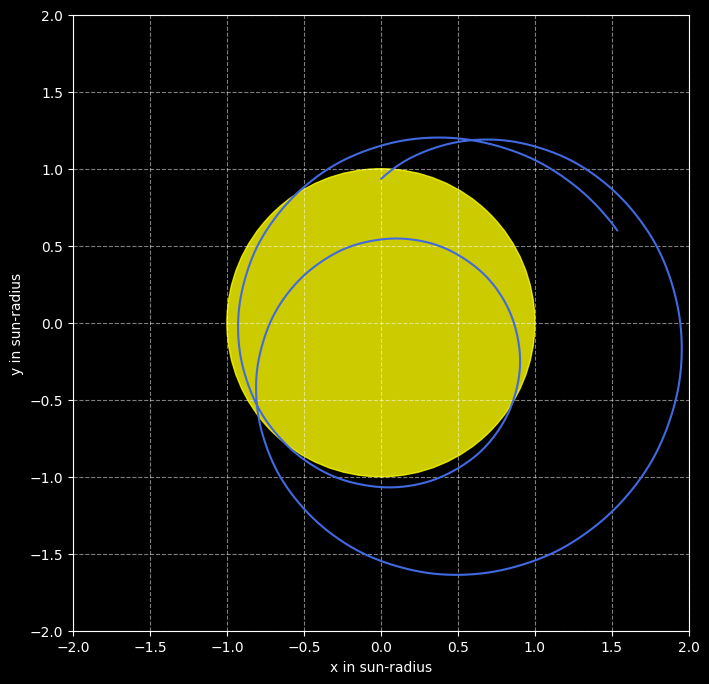

In [130]:
# We plot now the trajectory of the SSB w.r.t the Sun using matplotlib
from matplotlib import pyplot as plt

# We only plot the x, y components (view on the ecliptic plane)
ssb_wrt_sun_position_scaled_xy = ssb_wrt_sun_position_scaled[:, 0:2]

# Set a dark background... since... space is dark
plt.style.use('dark_background')

# Create a figure and ax.
fig, ax = plt.subplots(figsize=(12, 8))

# Create a yellow circle that represents the Sun, add it to the ax
sun_circ = plt.Circle((0.0, 0.0), 1.0, color='yellow', alpha=0.8)
ax.add_artist(sun_circ)

# Plot the SSB movement
ax.plot(ssb_wrt_sun_position_scaled_xy[:, 0], \
        ssb_wrt_sun_position_scaled_xy[:, 1], \
        ls='solid', color='royalblue')

# Set some parameters for the plot, set an equal ratio, set a grid, and set
# the x and y limits
ax.set_aspect('equal')
ax.grid(True, linestyle='dashed', alpha=0.5)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

# Some labelling
ax.set_xlabel('x in sun-radius')
ax.set_ylabel('y in sun-radius')

# Saving the figure in high quality.
plt.savefig('SSB_WRT_SUN.png', dpi=300)

In [131]:
# How many days is the SSB outside the Sun? First, we compute the euclidean
# distance between the SSB and Sun.
ssb_wrt_sun_distance_scaled = np.linalg.norm(ssb_wrt_sun_position_scaled, \
                                             axis=1)

print('computation time: %s days\n' % delta_days)

# Compute number of days outside the Sun
ssb_outside_sun_delta_days = len(np.where(ssb_wrt_sun_distance_scaled > 1)[0])

print('fraction of time where the ssb\n' \
      'was outside the sun: %s %%' % (100 * ssb_outside_sun_delta_days \
                                      / delta_days))

computation time: 10000 days

fraction of time where the ssb
was outside the sun: 64.64 %
